In [1]:
!which python
!python --version
!python -m pip show torch

/home/charlie/miniconda3/envs/torch/bin/python
Python 3.10.19
Name: torch
Version: 2.5.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /home/charlie/miniconda3/envs/torch/lib/python3.10/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision


In [ ]:
import torch

print(torch.__version__, "CUDA available:", torch.cuda.is_available(), "CUDA runtime:", torch.version.cuda)

/home/charlie/miniconda3/envs/torch/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


2.5.1 CUDA available: True CUDA runtime: 12.1


In [17]:
import os
import kagglehub
from pathlib import Path

print("kagglehub version:", kagglehub.__version__)

home = str(Path.home())
root_dir = home + "/.cache/kagglehub/datasets"
data_dir = root_dir + "/smashik/plant-seedlings-classification"


if not os.path.exists(data_dir):
    data_dir = kagglehub.dataset_download("smashik/plant-seedlings-classification", path=root_dir)

data_dir = data_dir + "/versions/1"
print(os.path.exists(data_dir))
print("Path to dataset files:", data_dir)


kagglehub version: 0.3.13
True
Path to dataset files: /home/charlie/.cache/kagglehub/datasets/smashik/plant-seedlings-classification/versions/1


In [ ]:
import torch
from torch import nn  # neural network module
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import models  # pre-defined models
from torchvision.utils import make_grid
from torchvision import transforms as tsfm  # provides common image transformations
from torchvision.datasets import ImageFolder  # for loading image datasets, need special folder structure

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # process bar
from PIL import Image
from pathlib import Path  # path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

In [22]:
# Set Hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.001
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [23]:
class Train_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root=root_dir, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

    def get_classes(self):
        return self.data.classes

    def get_class_to_idx(self):
        return self.data.class_to_idx


class Pred_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = list(Path(root_dir).glob("*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        img = img.unsqueeze(0)  # add batch dimension in specific index
        return img

/home/charlie/.cache/kagglehub/datasets/smashik/plant-seedlings-classification/versions/1/train exists
/home/charlie/.cache/kagglehub/datasets/smashik/plant-seedlings-classification/versions/1/test exists
4750
torch.Size([3, 224, 224]) 0
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
torch.Size([1, 3, 224, 224])


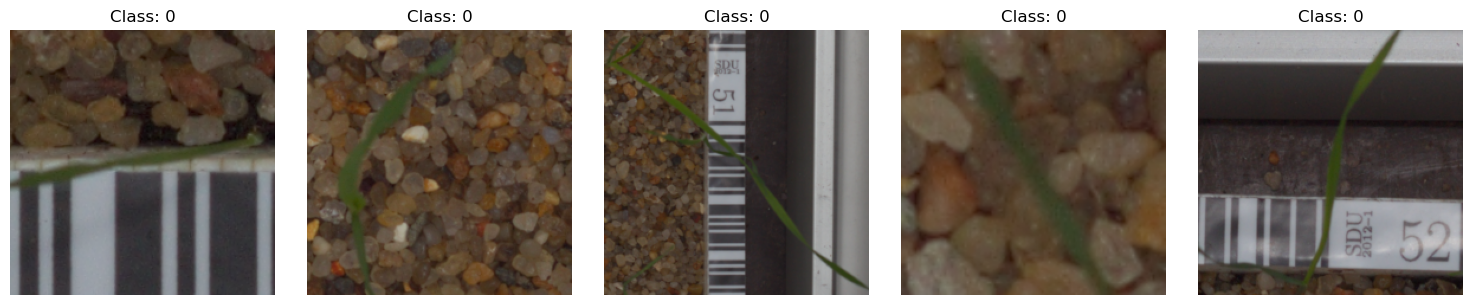

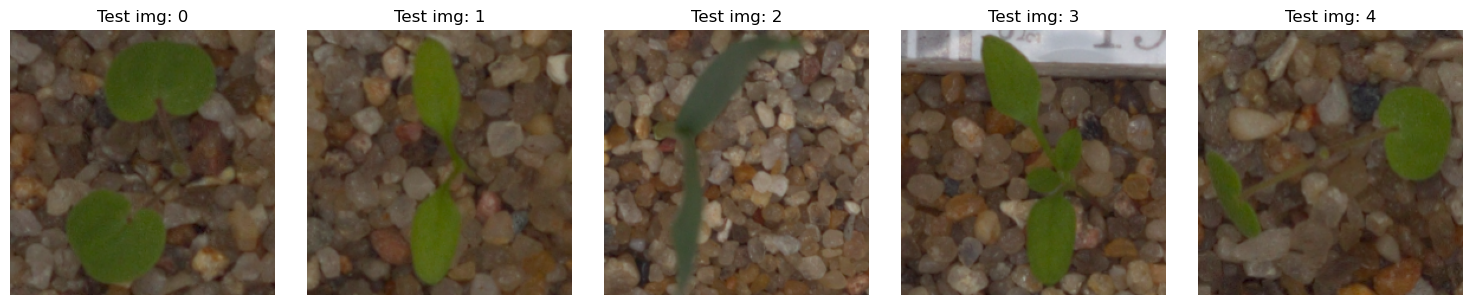

In [37]:
# specified data directories -----------------------------------------------------------------------
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
if os.path.exists(train_dir) or not os.path.exists(test_dir):
    print(train_dir, "exists")
    print(test_dir, "exists")
else:
    raise FileNotFoundError("Train or test directory not found in the dataset path.")

# define image transformations ---------------------------------------------------------------------
transform = tsfm.Compose([tsfm.Resize((224, 224)), tsfm.ToTensor()])

# create dataset instances
whole_set = Train_data(root_dir=train_dir, transform=transform)
print(len(whole_set))
img, label = whole_set[0]
print(img.shape, label)
print(whole_set.get_classes())
print(whole_set.get_class_to_idx())

test_set = Pred_data(root_dir=test_dir, transform=transform)
img = test_set[0]
print(img.shape)

# visualize some images from the dataset -----------------------------------------------------------
num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (img, label) in enumerate(whole_set):
    axs[i].imshow(img.permute(1, 2, 0))  # change from (C, H, W) to (H, W, C) for opendv, matplotlib, numpy image
    axs[i].set_title(f"Class: {label}")
    axs[i].axis("off")
    num_images_to_display -= 1
    if num_images_to_display == 0:
        break
plt.tight_layout()
plt.show()

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, img in enumerate(test_set):
    axs[i].imshow(img[0].permute(1, 2, 0))
    axs[i].set_title(f"Test img: {i}")
    axs[i].axis("off")
    num_images_to_display -= 1
    if num_images_to_display == 0:
        break
plt.tight_layout()
plt.show()

In [ ]:
# split dataset into training and validation sets --------------------------------------------------
train_set, valid_set = random_split(whole_set, [0.8, 0.2])

# create data loaders for training and validation sets ---------------------------------------------
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)  # shuffle for training set, randomizes the order of data
"""
DataLoader(
    dataset=train_set,   # Dataset
    batch_size=32,       
    shuffle=True,        
    num_workers=4,       
    pin_memory=True      
)

A DataLoader can be seen as a dataset reader — it defines how the data should be loaded and how many
samples to return at once (the batch size).
Because of this, the Dataset must define what a single data sample is, which is why it needs to 
implement the __getitem__ method.
"""
# batches = 0
# for _, _ in train_loader:
#     batches += 1
# print(batches)  # 60 (4750 data * 0.8 split / 64 batch_size = 59.3 => get 60)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

60


In [27]:
# resnet50 checking --------------------------------------------------------------------------------
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(resnet_model)  # print the model architecture
print()
for layer in resnet_model.children():
    print(layer)  # print all info of the layer in detail
print()
for name, layer in resnet_model.named_children():
    print(name, "→", layer)  # print the layer info including layer name in detail
print()
for name, param in resnet_model.named_parameters():
    print(name, param.shape, param.requires_grad)  # we can choose the specified layers to print info
print()
"""
    conv1 → bn1 → relu → maxpool → layer1 → layer2 → layer3 → layer4 → avgpool → fc
    layer{stage}.{block}.{submodule}.{parameter}
"""
# freeze all layers except the last classification layer (every layer include a few blocks)
for param in resnet_model.parameters():
    param.requires_grad = False
for param in resnet_model.fc.parameters():
    param.requires_grad = True

# freeze all layers except the last layer4 and classification layer
for param in resnet_model.parameters():
    param.requires_grad = False
for param in resnet_model.layer4.parameters():
    param.requires_grad = True
for param in resnet_model.fc.parameters():
    param.requires_grad = True


# print the input feature dimension of the last classification layer
print(resnet_model.fc.in_features)


# create model class using pretrained ResNet-50 ----------------------------------------------------
class resnet_50(nn.Module):
    def __init__(self, num_classes=12):
        super(resnet_50, self).__init__()
        # pytorch built-in models
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # load pretrained weights

        # set model layers trainable, can be back propagated and updated during training
        # default is True
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # redifine/customize last classification layer
        self.resnet50.fc = nn.Linear(2048, num_classes)  # 2048 is the input feature dimension of last layer, which is fixed for backbone of resnet50,
        # and num_classes is the output dimension, which is defined for classification task

    def forward(self, x):
        # forward pass through the ResNet-50 backbone and classification head
        x = self.resnet50(x)  # the input dimension must be [Batch_size, dimension, height, width]
        """
            About the Batch_size, it represents the number of images processed together in one forward/backward pass.
            It means how many images are forward into the model simultaneously, and how many gradients are computed together during backpropagation.

            In general, the backpropagation algorithm uses the average gradient over the entire batch to update the model parameters.
            If we want to change this behavior, we need to modify the training loop accordingly.

            The detailed information is provided below.
        """
        return x

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
# test model for debug -----------------------------------------------------------------------------
model = resnet_50(num_classes=12).cuda()  # move model to GPU

# find the first layer dimension
for name, layer in model.resnet50.named_children():
    if name == "conv1":
        print(name, "→", layer)
"""
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

    out_channels will output 64 feature map after the first conv layer, which is defined by the conv layer
"""

x = torch.rand(1, 3, 224, 224).cuda()  # due to the first layer conv1 dimension, need to make sure the dimension is 3, and input one image at once
# print(x)
y = model(x)  # forward pass, the nn.Module define __call__() function to call forward() function
"""
    Because the __call__ function would process the input data before passing it to the forward function,
    including hooks, pre, grad, and post processing, etc.
"""
print(y)

conv1 → Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[ 0.0536,  0.0912,  0.1032,  0.1193, -0.0036, -0.0813,  0.0038, -0.0517,
          0.0798,  0.0032, -0.1408,  0.0211]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
# because the DataLoader is iterable obj, it can not index directly.
data, label = next(iter(train_loader))
len(label)  # batch size 64

64

In [69]:
# define the training function ---------------------------------------------------------------------
def train(model, criterion, optimizer, train_loader, epoch, total_epochs, batch_size):
    model.train()  # training mode
    # train_loss, train_acc = [], []

    # tqdm_iter = tqdm(
    #     train_loader, desc="Epoch: {}/{} ({}%) | Training loss: NaN".format(epoch, total_epochs, int(epoch / total_epochs * 100)), leave=False
    # )
    epoch_loss, epoch_acc = 0.0, 0.0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, target = data.cuda(), label.cuda()  # data and label to gpu

        """
            訓練過程中的三個關鍵步驟：

            1 loss.backward()
                - loss 會沿著計算圖 (computation graph) 反向傳遞，
                對所有 requires_grad=True 的參數計算梯度 (gradient)。
                - 結果會存放在對應參數的 param.grad 裡。
                - model 中每個需要訓練的 weight / bias 都會有自己的 .grad 張量。
                - 注意: PyTorch 的梯度預設是「累加」(accumulate),
                也就是新的 batch 計算出來的梯度會加到前一個 batch 的 grad 上，
                不會自動清空。

            2 optimizer.zero_grad()
                - 清空前一次的梯度，為下一個 batch 做準備。
                - 實作上會遍歷 optimizer 內註冊的所有參數，把 param.grad 設為 0 或 None。
                - 因為梯度是預設累加的，所以必須在每個 batch 開始前手動清除, 
                避免梯度錯誤累積，確保每個 batch 的更新獨立。

            3 optimizer.step()
                - 依照梯度更新參數 (weights)。
                - optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
                意味著：
                    1. model.parameters() 將模型中所有可訓練參數的參照 (reference) 交給 optimizer。
                    2. 呼叫 step() 時, optimizer 會自動走訪這些參數, 並且依照 optimizer 的規則來更新參數。
                    3. 概念上等價於：
                        for param in optimizer.params:
                            param.data = param.data - lr * param.grad
                - loss.backward() 計算「要怎麼改」；
                optimizer.step() 真的「把 weight 改掉」。

            ----------------------------------------------------------
            完整的訓練步驟流程：

            for each batch in train_loader:
                1. optimizer.zero_grad()     # 清除上一輪梯度
                2. output = model(data)      # forward: 建立計算圖
                3. loss = criterion(output)  # 計算 loss (建立圖的最終節點)
                4. loss.backward()           # backward: 從 loss 反向傳遞梯度
                5. optimizer.step()          # 根據梯度更新參數

            ----------------------------------------------------------
            為什麼「清空梯度」要用 optimizer 來做？

            - 因為 optimizer 內部記錄了「哪些參數」需要被更新。
            - 它知道自己要處理哪些參數(param_groups),
            所以最安全、最一致的做法就是讓 optimizer 去清空這些梯度。
            - 若手動清除 model.parameters() 的梯度，可能遺漏部分參數，
            而 optimizer.zero_grad() 保證與 step() 管理的參數一致。
        """
        output = model(data)  # forward
        loss = criterion(output, target)
        # compute the loss using prediction and label, this step will find the correct output (12 numbers to 1)
        # to compute the error with the target

        optimizer.zero_grad()  # Clear gradients from the previous iteration
        loss.backward()  # Compute new gradients from the current batch and store them in param.grad
        optimizer.step()  # Update model parameters using the computed gradients

        # find the max number , to float, compute with mean, to scalar
        # get the acc in this batch
        acc = (output.argmax(dim=1) == target).float().mean().item()
        epoch_loss += loss.item()
        epoch_acc += acc

        # tqdm_iter.set_description(
        #     "Epoch: {}/{} ({}%) | Training loss: {:.6f} | Training Acc: {:.6f}".format(
        #         epoch + 1, total_epochs, int((epoch + 1) / total_epochs * 100), round(loss.item(), 6), round(acc, 6)
        #     )
        # )

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader) # len(train_loader) == batches, get the avg loss/acc per batch, it is a standard criteria

In [ ]:
# debug "train" function
criterion = nn.CrossEntropyLoss(reduction="mean") # here, we can control how to "sum" the loss in a batch
"""
When reduction="none", it means PyTorch will not automatically aggregate the loss values.
Instead, it returns the loss for each individual sample, allowing us to decide how to combine them manually.

ex: we can compute a weighted sum of the losses:
loss = criterion(output, target)
print(loss)  # tensor([0.4170, 1.6447])
weights = torch.tensor([0.3, 0.7])
loss_weighted = (loss * weights).sum() / weights.sum()
"""
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss, acc = train(
    model,
    criterion,
    optimizer,
    train_loader,
    epoch=1,
    # "epoch" is a conceptual term that describes how many times the model sees the full dataset.
    # It is not used automatically by the API; you have to use it yourself in the training loop.
    total_epochs=1,
    batch_size=batch_size,
)

print(loss, acc)
# acc's max is 1
# loss is unlimited, depends on loss computation

1.0956245998541514 0.6254340281089147


In [72]:
# define the validation function -------------------------------------------------------------------
def valid(model, criterion, valid_loader, epoch, total_epochs, batch_size):
    model.eval()

    # tqdm_iter = tqdm(
    #     valid_loader, desc="Epoch: {}/{} ({}%) | Valid loss: NaN".format(epoch, total_epochs, int(epoch / total_epochs * 100)), leave=False
    # )
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():  # stop make the computation graph
        for batch_idx, (data, label) in enumerate(valid_loader):
            data, target = data.cuda(), label.cuda()
            output = model(data)
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean().item()
            epoch_loss += loss.item()
            epoch_acc += acc

            # tqdm_iter.set_description(
            #     "Epoch: {}/{} ({}%) | Valid loss: {:.6f} | Valid Acc: {:.6f}".format(
            #         epoch + 1, total_epochs, int((epoch + 1) / total_epochs * 100), round(loss.item(), 6), round(acc, 6)
            #     )
            # )

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

In [73]:
# debug "valid" function
criterion = nn.CrossEntropyLoss()
loss, acc = valid(
    model,
    criterion,
    valid_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

1.5307928880055746 0.49992283980051677


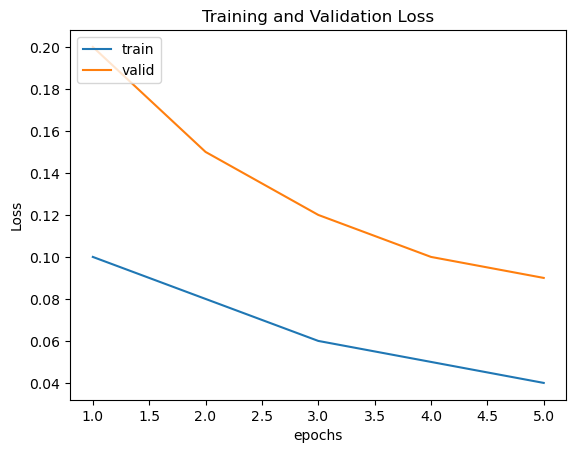

In [75]:
def Plot(title, ylabel, epochs, train_loss, valid_loss):
    plt.figure()
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(ylabel)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.legend(['train', 'valid'], loc='upper left')

# debug "Plot" function
debug_epochs = [1, 2, 3, 4, 5]
debug_train_loss = [0.1, 0.08, 0.06, 0.05, 0.04]
debug_valid_loss = [0.2, 0.15, 0.12, 0.1, 0.09]

Plot("Training and Validation Loss", 'Loss', debug_epochs, debug_train_loss, debug_valid_loss)
plt.show()

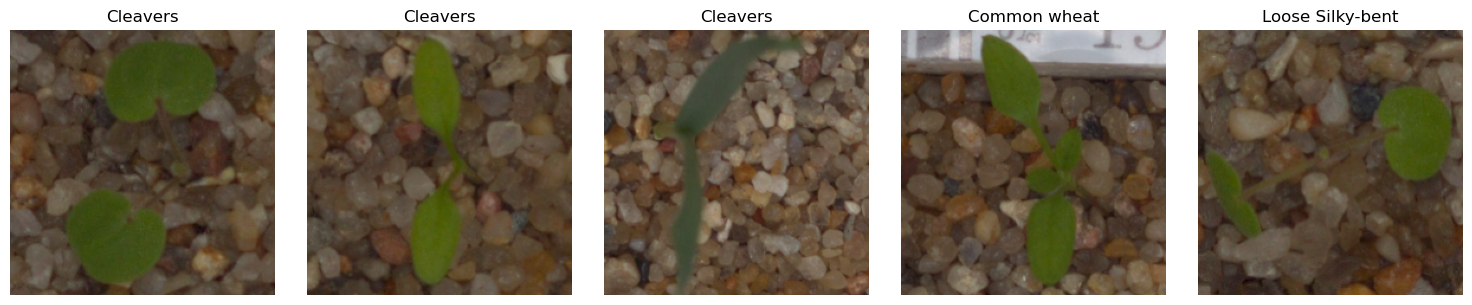

In [79]:
def predict(loader, model):
    model.eval()  # the mode is the same as validation
    preds = []
    # for data in tqdm(loader):
    for data in loader:
        pred = model(data.cuda())  # no loss step, just forward
        cls = torch.argmax(pred, dim=1)
        preds.append(cls)
    return preds


# Visualize Predict result
def view_pred_result(preds, num_images_to_display=5):
    labels = [
        "Black-grass",
        "Charlock",
        "Cleavers",
        "Common Chickweed",
        "Common wheat",
        "Fat Hen",
        "Loose Silky-bent",
        "Maize",
        "Scentless Mayweed",
        "Shepherds Purse",
        "Small-flowered Cranesbill",
        "Sugar beet",
    ]
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
    for i, img in enumerate(test_set):
        axs[i].imshow(img[0].permute(1, 2, 0))
        axs[i].set_title(labels[preds[i].item()])
        axs[i].axis("off")
        num_images_to_display -= 1
        if num_images_to_display == 0:
            break
    plt.tight_layout()
    plt.show()


# debug "Predict" function & "View_Predict_result" function
test_dir = os.path.join(data_dir, "test")
transform = tsfm.Compose(
    [
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ]
)
test_set = Pred_data(root_dir=test_dir, transform=transform)
model = resnet_50(num_classes=12).cuda()  # pretrained resnet_50
preds = predict(test_set, model)
view_pred_result(preds)

3
Avg train Loss: 0.7252178733547529, Avg train acc: 0.7640625
Avg valid Loss: 0.4897483070691427, Avg valid acc: 0.8326388875643412
Avg train Loss: 0.23549284208565952, Avg train acc: 0.91796875
Avg valid Loss: 0.2992161065340042, Avg valid acc: 0.8969521601994832
Avg train Loss: 0.15678975445528825, Avg train acc: 0.9427951395511627
Avg valid Loss: 0.27193775624036787, Avg valid acc: 0.9192901253700256


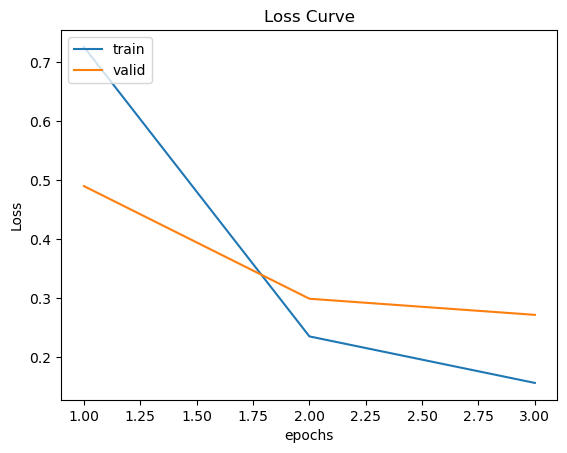

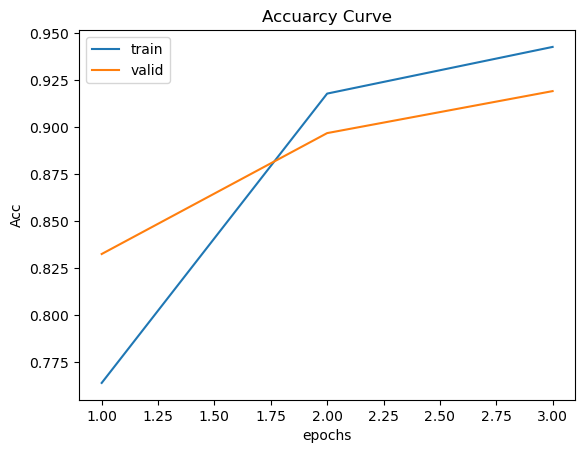

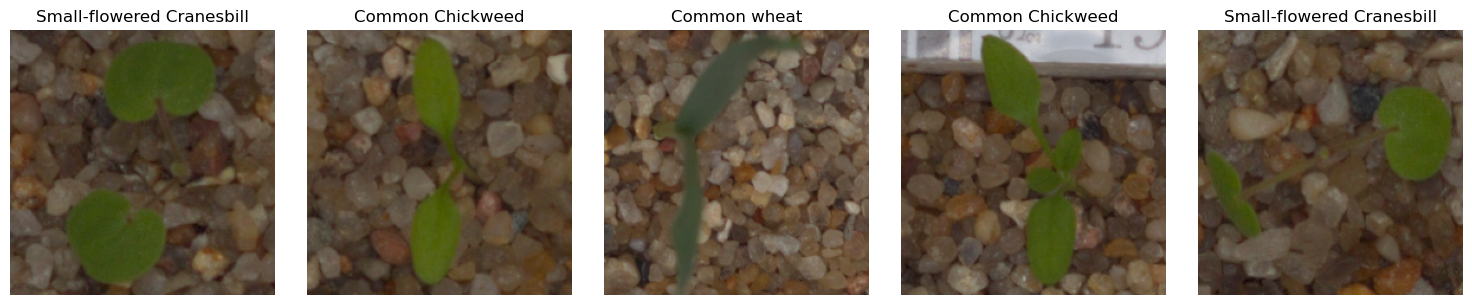

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)  # dataloader shuffle would use this, independent on native random
torch.cuda.manual_seed_all(manualSeed)  # this is for gpu
torch.backends.cudnn.deterministic = True  # limit the cudnn use the stochastic algorithm, which generate different result.
torch.backends.cudnn.benchmark = False
# This flag lets cuDNN auto-tune the best convolution algorithms for your hardware.
# suggestion: Use benchmark=True when input sizes are constant;
# False it if input sizes vary, as configuring the optimal process based on different inputs can
# offset the computation time required for optimization.

# This setting will be cached. It will be clear when we restart the jupyter kernel.
"""
例如以下任一行都會觸發初始化：

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.manual_seed(999)
torch.rand(1, device="cuda")  # ← 最常見
model.cuda()                  # ← 移動模型到 GPU
tensor.to("cuda")             # ← 移動 Tensor 到 GPU


- 當第一次使用 GPU 時,PyTorch 會：
- 啟動 CUDA driver;
- 載入 GPU kernel;
- 分配預設的 CUDA stream;
- 建立亂數生成器 (RNG);
- 建立 cuDNN context(如果啟用 cuDNN)。
這個過程會花一點時間（通常幾百毫秒），所以第一次呼叫 CUDA 的操作會慢一點。

----
torch.cuda.init() 只是啟動 CUDA runtime(載入驅動、建立 context),
不會初始化 cuDNN、記憶體池、或運算 kernel。

PyTorch 採用 延遲初始化 (lazy initialization) 設計，
真正的 GPU 初始化是在第一次進行運算（如 forward/backward)時發生。

所以雖然手動呼叫 torch.cuda.init() 可以提早載入驅動、略微預熱，
但要讓記憶體分配與 kernel 都穩定，仍需實際跑一次模型(跑一次 dummy forward/backward)。
"""
# Set Hyperparameters
epochs = 3
batch_size = 64
learning_rate = 0.001
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

import gc


def clear_cache():
    gc.collect()  # clear python obj in cpu cache
    torch.cuda.empty_cache()  # clear gpu cache


# define traing code
def main():
    clear_cache()
    # initial transform
    transform = tsfm.Compose(
        [
            tsfm.Resize((224, 224)),
            tsfm.ToTensor(),
        ]
    )

    # initial dataset
    whole_set = Train_data(root_dir=train_dir, transform=transform)
    test_set = Pred_data(root_dir=test_dir, transform=transform)

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    # initial dataloader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = resnet_50(num_classes=12).cuda()  # to gpu

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
        epoch_list.append(epoch + 1)

        # training
        loss, acc = train(model, criterion, optimizer, train_loader, epoch=epoch, total_epochs=epochs, batch_size=batch_size)
        train_loss.append(loss)
        train_acc.append(acc)
        print(f"Avg train Loss: {loss}, Avg train acc: {acc}")

        # validation
        loss, acc = valid(model, criterion, valid_loader, epoch=epoch, total_epochs=epochs, batch_size=batch_size)
        valid_loss.append(loss)
        valid_acc.append(acc)
        print(f"Avg valid Loss: {loss}, Avg valid acc: {acc}")

    Plot("Loss Curve", "Loss", epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", "Acc", epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)


main()
clear_cache()